<a href="https://colab.research.google.com/github/stefanogiagu/corso_AI_2024/blob/main/notebooks/es4MetodiAI_Fis2024_Es4_DecisionTree_RandomForest_SOLUTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Esercitazione 4: classificazione stato di un modello di Ising 2D e predizione del suo stato di magnetizzazione media con modelli di Decision Trees e Random Forests

**Task:** implementare algoritmi di classificazione e regressione basati su alberi e foreste di alberi di decisioni binarie con bagging per lo studio di un sistema di ising in 2D con condizioni periodiche al contorno

In [4]:
!rm -rf ising_conf.dat.gz
!rm -rf ising_conf.dat
!rm -rf ising_label.dat.gz
!rm -rf ising_label.dat
!rm -rf JetSubStruct.dat.gz
!wget http://giagu.web.cern.ch/giagu/CERN/ising_conf.dat.gz
!wget http://giagu.web.cern.ch/giagu/CERN/ising_label.dat.gz
!gunzip ising_conf.dat.gz
!gunzip ising_label.dat.gz

--2024-04-03 05:05:07--  http://giagu.web.cern.ch/giagu/CERN/ising_conf.dat.gz
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.21.205, 2001:1458:d00:34::100:59
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.21.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2953855 (2.8M) [application/gzip]
Saving to: ‘ising_conf.dat.gz’

ising_conf.dat.gz   100%[===================>]   2.82M   822KB/s    in 3.5s    

2024-04-03 05:05:11 (822 KB/s) - ‘ising_conf.dat.gz’ saved [2953855/2953855]

--2024-04-03 05:05:11--  http://giagu.web.cern.ch/giagu/CERN/ising_label.dat.gz
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.21.205, 2001:1458:d00:34::100:59
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.21.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86723 (85K) [application/gzip]
Saving to: ‘ising_label.dat.gz’

ising_label.dat.gz  100%[===================>]  84.69K   324KB/s    in 0.3s    

2024-04

### Informazioni di base sul Modello di Ising 2D ###

dettagli (definizione teorica e simulazione) nella [nota](https://vixra.org/pdf/1710.0021v2.pdf).

È costituito da una serie di spin (che possono assumere solo i valori -1 (down) e +1 (up)) interagenti tra loro, posti ai vertici di un reticolo quadrato bidimensionale. La dinamica del sistema (in assenza di campo magnetico esterno) è descritta dall'Hamiltoniana:

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

in cui gli indici del reticolo $i,j$ sono associati ai primi vicini di un reticolo 2D quadrato di lato $L$, e $J$ è un parametro di scala arbitrario che definisce la scala dell'energia di interazione tra gli spin $S_i$.
Si utilizzano condizioni periodiche al contorno sul reticolo.

Si può dimostrare che questo sistema presenta una transizione di fase nel limite termodinamico da un sistema ordinato con tutti gli spin allineati (ferromagnete ordinato) a temperatura zero, a una fase disordinata con spin competamente random, ad alta temperatura. La temperatura critica a cui avviene la transizione è data da $T_c/J=1/\log(1+\sqrt{2})\approx 2.26$.


**Dataset:**

Viene fornito
25k configurazioni con $T/J$ uniforme in $[0,5]$ di un modello ising 2D su un reticolo $28\times 28$ simulato tramite un semplice Monte Carlo tipo Metropolis.

Il campione è disponibile in due file:

* configurazioni: *ising_conf.dat*
* label: *ising_label.dat*

NOTA BENE: le configurazioni sono salvate in file testuali, che letti con numpy (*np.loadtxt*) forniscono tensori di shape *(25000x28,28)* che vanno reshaped nel formato *(25000,28x28)* e *(25000,28,28)* per essere utilizzati con scikit-learn in modo efficiente.

**Parte 1:**

Loading, analisi e pre-processamento del dataset:

1.   leggere le configurazioni e salvarle in due tensori numpy *data(25000,784)* e *data_2d(25000,28,28)*, usando il metodo *np.loadtxt* di numpy. Idem per le temperature: *temp(25000,1)*
2.   poiché è noto che vicino alla temepratura critica $T_c$, la lunghezza delle correlazioni ferromagnetiche diverge, rendendo difficile identificare la fase, dvidere il campione in tre sotto-campioni corrispondenti alle classi:

* ordinato: $T<2.0$
* critico: $2.0\leq T\leq 2.5$
* disordinato: $T>2.5$

     costruendo un nuovo tensore numpy di label *(0,1,2)* da associare ad ogni configurazione in *data/data_2d*.
    
3.   visualizzare un evento per ciascuna classe usando matplotlib: *plt.imshow*  (nota: usare il tensore in formato (28,28) *data_2d*)


In [5]:
#code

In [6]:
#@title Soluzione 1.1
import numpy as np

rnd_ini = 123456
np.random.seed(rnd_ini) # shuffle random seed generator

# Ising model parameters
L=28 # size del reticolo
J=1.0 # Ising interaction (1 ferromagnetico, -1 anti-ferromagnetico)
T_c=2.26 # Temperatura critica

#leggiamo le configurazioni ising dal file usando numpy (25k esempi oguno da 28x28 spin)
data = np.loadtxt('ising_conf.dat')
data = data.reshape(25000,28*28)
print('data shape: ',data.shape)

# al fine di visualizzare alcune delle configurazioni convertiamo il vettore numpy un tensore di 25K eventi ognuno
# formato da una matrice 28x28 di spin
data_2d = data.reshape(data.shape[0],28,28)
print('data_2d shape: ',data_2d.shape)

#leggiamo da file le label associate:
temp = np.loadtxt('ising_label.dat')
print('temp shape: ',temp.shape)

data shape:  (25000, 784)
data_2d shape:  (25000, 28, 28)
temp shape:  (25000,)


In [7]:
#@title Soluzione 1.2
# dividiamo il campione in 3 campioni sulla base dello stato (ordinato, critico, disordinato)
# T/J < 2.0 ordinato
# T/J in [2.0,2.5] critico
# T/J > 2.5 disordinato

ord_sele = (temp < 2.0)
cri_sele = ((temp >= 2.0) & (temp <= 2.5))
dis_sele = (temp > 2.5)

labels = np.zeros(shape=temp.shape)
labels[ord_sele]=0
labels[cri_sele]=1
labels[dis_sele]=2

print('labels shape: ',labels.shape)
print('# conf. ordinate: ', labels[ord_sele].shape[0])
print('# conf. critiche: ', labels[cri_sele].shape[0])
print('# conf. disordinate: ', labels[dis_sele].shape[0])

labels shape:  (25000,)
# conf. ordinate:  9953
# conf. critiche:  2563
# conf. disordinate:  12484


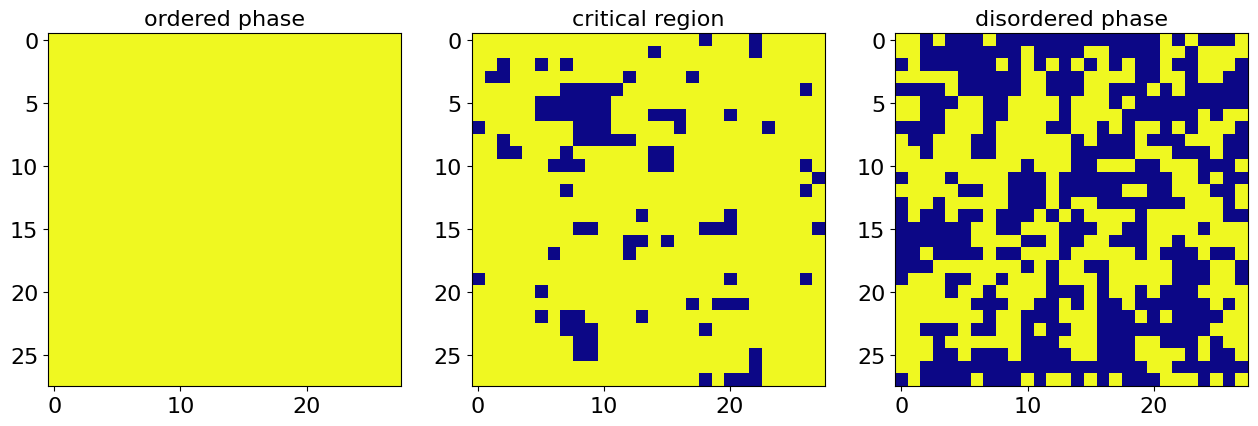

In [8]:
#@title Soluzione 1.3
import matplotlib.pyplot as plt

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

ieve = 11 #seleziono un evento a caso di ogni classe
axarr[0].imshow((data_2d[ord_sele])[ieve],**cmap_args)
axarr[0].set_title('ordered phase',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow((data_2d[cri_sele])[ieve],**cmap_args)
axarr[1].set_title('critical region',fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow((data_2d[dis_sele])[ieve],**cmap_args)
axarr[2].set_title('disordered phase',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

**Parte 2**:

Implementazione di dueclassificatori basati su un **albero di decisione binaria, una random forest (basata su bagging)**, addestrati alla task di identificare la classe (0,1,2) delle configurazioni (ordinata, critica, disordinata).

1.   dividere campione e label in tre sotto-campioni: **training, validation e test set** (*60-20-20 %*) usando sklearn:

`from sklearn.model_selection import train_test_split`

2.   implementare e **addestrare sul campione di training** i due classificator:

```
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
```

3.   usando come metrica l'accuracy, **ottmizzare gli iperparametri** dei modelli (NOTA: valutare l'accuracy sia sul **training set** che sul **validation set** e usare quest'ultima come misura non distorta delle prestazioni in generalizzazione del modello):

*   DecisionTreeClassifier: *max_depth*, 10 valori in [1,10]
*   RandomForestClassifier: *n_estimators*, 10 valori in [2,100], e *min_samples_split*, testare 2 valori per il parametro =2 e =10000

4.  insieme all'accuracy stimata sul test calcolare anche l'accuracy sul campione Out-Of-Bag (OOB: disponibile solo per le RandomForest, vedi la nota successiva per una spiegazione)
5.   graficare accuracy e stima OOB sul training e test set in funzione del valore del parametro ottimizzato
6.   confrontare in termini di **accuracy media** e **matrice di confusione** calcolate sul *campione di test* i risultati ottenuti con i due modelli ottimizzati

**NOTA: RandomForest in scikit-learn**

**Iperparametri**

Usiamo l'implementazione in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) che ha due iperparamteri principali che possono modificare anche sensibimente le prestazioni del modello e il livelo di overfit/underfit: il numero di alberi nella foresta e la complessità di ciascun albero: il primo è controllato dal parametro `n_estimators`, mentre la complesiità è controllata da vari parametri `min_samples_split`, `min_samples_leaf`, `min_impurity_decrease`, etc, in parte correlati tra loro. Nell'esempio in esame per semplicità useremo solo `min_samples_split` (governa il numero di campioni necessari per procedere ad uno split di un nodo: più alto è il numero minore sarà la segmentazione e le diramazioni dell'albero.
Per il semplice DecisionTreeClassifier useremo *max_depth*: che controlla la massima profondità dell'albero.

**Stima OOB (Out Of Bag)**

È un metodo molto utile per ottimizzare gli iperparametri quando si usano metodi di bagging: consiste nel verificare quanto bene funziona il classificatore su quegli eventi del training set che non sono stati usati perchè non campionati nella technica di boostrap. Gioca un ruolo simile alla k-fold cross-validation. È disponibile come metodo di RandomForestClassifier: *.oob_score_*

In [9]:
#code

In [10]:
#@title Soluzione 2.1
##Dividiamo il campione per il training
from sklearn.model_selection import train_test_split
train_to_rest_ratio=0.6 # training sample 60%
vali_to_test_ratio=0.5  #  validation and test sets: 50%-50% of remianining 40%

# selezioniamo random data points dai campioni ordinati e disordinati per cerare training e test
X_train,X,Y_train,Y=train_test_split(data,labels,train_size=train_to_rest_ratio, shuffle=True, random_state=rnd_ini)
X_vali,X_test,Y_vali,Y_test=train_test_split(X,Y,train_size=vali_to_test_ratio, shuffle=True, random_state=rnd_ini)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_vali shape:', X_vali.shape)
print('Y_vali shape:', Y_vali.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (15000, 784)
Y_train shape: (15000,)
X_vali shape: (5000, 784)
Y_vali shape: (5000,)
X_test shape: (5000, 784)
Y_test shape: (5000,)


max_depth acc val_acc
1 0.49906666666666666 0.4922
3 0.7362 0.7308
5 0.8198 0.8138
7 0.8514 0.8346
9 0.8938666666666667 0.8282
11 0.9408 0.8218
13 0.9579333333333333 0.8262
15 0.9686 0.8262
17 0.9752666666666666 0.8232
20 0.9823333333333333 0.8294
max accuracy:  0.8346  per max_depth =  7
Test accuracy:  0.832
Confusion Matrix:
[[0.9491353  0.00406918 0.04679552]
 [0.55130785 0.01408451 0.43460765]
 [0.09184076 0.00670083 0.90145842]]


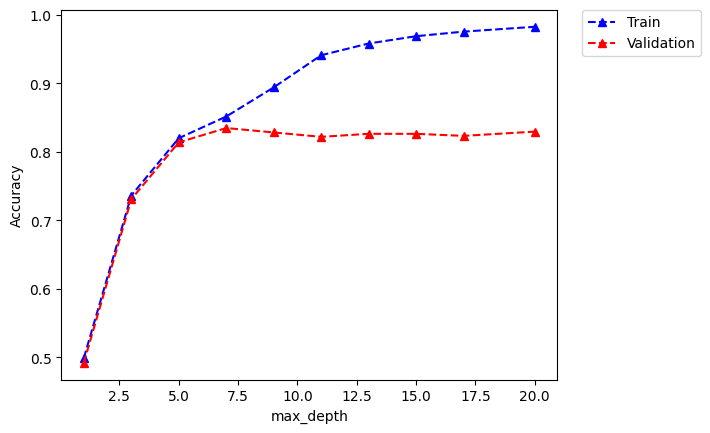

In [11]:
#@title Soluzione 2 DecisionTree
# Scikit-learn DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
import time
import warnings
import math
#disabilitiamo messaggi di warning
warnings.filterwarnings("ignore")

max_depth_range = np.linspace(1,20,10, dtype='int')

accuracy = []
val_accuracy = []
print('max_depth acc val_acc')
for max_depth in max_depth_range:
    DT_clf = DecisionTreeClassifier(max_depth=max_depth)
    DT_clf.fit(X_train, Y_train)
    acc = DT_clf.score(X_train, Y_train)
    val_acc = DT_clf.score(X_vali, Y_vali)
    accuracy.append(acc)
    val_accuracy.append(val_acc)
    print(max_depth, acc, val_acc)

best_max_depth = max_depth_range[val_accuracy.index(max(val_accuracy))]
print('max accuracy: ', max(val_accuracy), ' per max_depth = ', best_max_depth)

DT_clf = DecisionTreeClassifier(max_depth=best_max_depth)
DT_clf.fit(X_train, Y_train)
test_acc = DT_clf.score(X_test, Y_test)
print('Test accuracy: ', test_acc)


test_pred = DT_clf.predict(X_test)
from sklearn.metrics import confusion_matrix
c_mat = confusion_matrix(Y_test, test_pred, normalize='true')
print("Confusion Matrix:")
print(c_mat)

plt.figure()
plt.plot(max_depth_range,accuracy,'--b^',label='Train')
plt.plot(max_depth_range,val_accuracy,'--r^',label='Validation')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
lgd=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [12]:
#@title Soluzione RandomForest A
# Scikit-learn Random Forest
from sklearn.ensemble import RandomForestClassifier
import time
import warnings
#disabilitiamo messaggi di warning
warnings.filterwarnings("ignore")

#Valore del numero di alberi
n_estimator_range=np.linspace(2,100,10, dtype='int')
leaf_size_range=[2,10000]

m=len(n_estimator_range)
n=len(leaf_size_range)

#Allocate Arrays for various quantities
RFC_OOB_accuracy=np.zeros((n,m))
RFC_train_accuracy=np.zeros((n,m))
RFC_vali_accuracy=np.zeros((n,m))
run_time=np.zeros((n,m))

print_flag=True

for i, leaf_size in enumerate(leaf_size_range):
    # Define Random Forest Classifier
    myRF_clf = RandomForestClassifier(
        n_estimators=n_estimator_range[0],
        max_depth=None,
        min_samples_split=leaf_size, # minimum number of sample per leaf
        oob_score=True,
        random_state=0,
        warm_start=True # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.
    )
    for j, n_estimator in enumerate(n_estimator_range):

        print('n_estimators: %i, leaf_size: %i'%(n_estimator,leaf_size))

        start_time = time.time()
        myRF_clf.set_params(n_estimators=n_estimator)
        myRF_clf.fit(X_train, Y_train)
        run_time[i,j] = time.time() - start_time

    # check accuracy
        RFC_train_accuracy[i,j]=myRF_clf.score(X_train,Y_train)
        RFC_OOB_accuracy[i,j]=myRF_clf.oob_score_
        RFC_vali_accuracy[i,j]=myRF_clf.score(X_vali,Y_vali)
        if print_flag:
            result = (run_time[i,j], RFC_train_accuracy[i,j], RFC_OOB_accuracy[i,j], RFC_vali_accuracy[i,j])
            print('{0:<15}{1:<15}{2:<15}{3:<15}'.format("time (s)","train score", "OOB estimate","validation score"))
            print('{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}'.format(*result))

n_estimators: 2, leaf_size: 2
time (s)       train score    OOB estimate   validation score
0.2105         0.9178         0.6552         0.7924         
n_estimators: 12, leaf_size: 2
time (s)       train score    OOB estimate   validation score
0.9065         0.9972         0.8807         0.9156         
n_estimators: 23, leaf_size: 2
time (s)       train score    OOB estimate   validation score
0.9936         0.9995         0.9082         0.9150         
n_estimators: 34, leaf_size: 2
time (s)       train score    OOB estimate   validation score
1.0324         0.9996         0.9125         0.9152         
n_estimators: 45, leaf_size: 2
time (s)       train score    OOB estimate   validation score
1.1521         0.9999         0.9132         0.9152         
n_estimators: 56, leaf_size: 2
time (s)       train score    OOB estimate   validation score
1.2840         1.0000         0.9148         0.9164         
n_estimators: 67, leaf_size: 2
time (s)       train score    OOB estimate   v

In [13]:
#@title Soluzione RandomForest B
best_acc = np.max(RFC_vali_accuracy)
index_best = np.unravel_index(RFC_vali_accuracy.argmax(), RFC_vali_accuracy.shape)
print('Best accuracy: ', best_acc, ' per n_estimators=', n_estimator_range[index_best[1]],
      ', min_samples_split=', leaf_size_range[index_best[0]])


myRF_clf = RandomForestClassifier(
        n_estimators=n_estimator_range[index_best[1]],
        max_depth=None,
        min_samples_split=leaf_size_range[index_best[0]],
        oob_score=True,
        random_state=0,
        warm_start=True
)

myRF_clf.fit(X_train, Y_train)
test_acc = myRF_clf.score(X_test, Y_test)
print('Test accuracy: ', test_acc)


test_pred = myRF_clf.predict(X_test)
from sklearn.metrics import confusion_matrix
c_mat = confusion_matrix(Y_test, test_pred, normalize='true')
print("Confusion Matrix:")
print(c_mat)

Best accuracy:  0.918  per n_estimators= 100 , min_samples_split= 2
Test accuracy:  0.9192
Confusion Matrix:
[[9.99491353e-01 0.00000000e+00 5.08646999e-04]
 [4.56740443e-01 1.89134809e-01 3.54124748e-01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


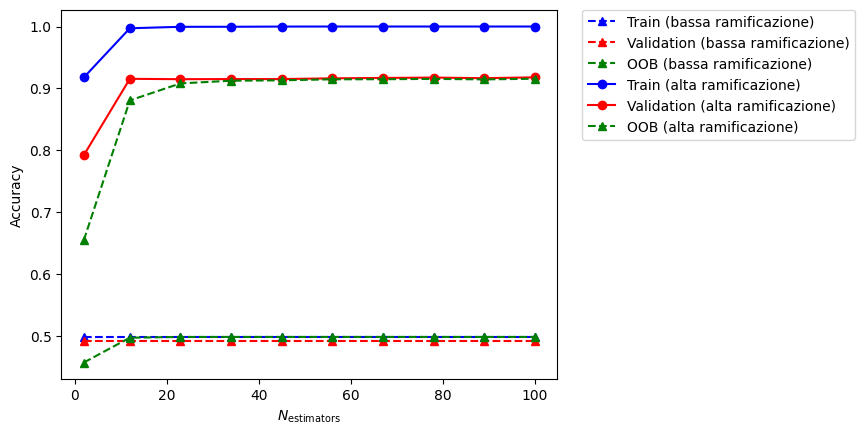

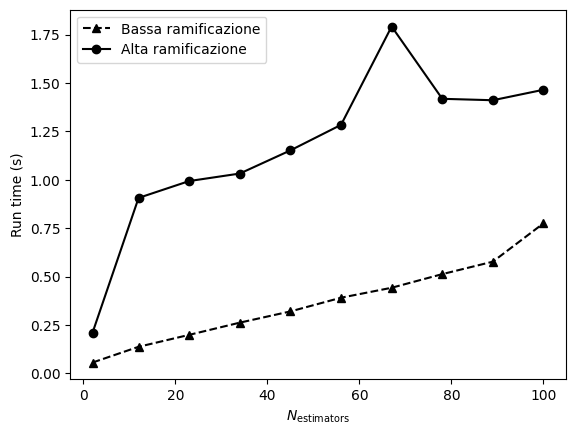

In [14]:
#@title Soluzione RandomForest C
plt.figure()
plt.plot(n_estimator_range,RFC_train_accuracy[1],'--b^',label='Train (bassa ramificazione)')
plt.plot(n_estimator_range,RFC_vali_accuracy[1],'--r^',label='Validation (bassa ramificazione)')
plt.plot(n_estimator_range,RFC_OOB_accuracy[1],'--g^',label='OOB (bassa ramificazione)')

plt.plot(n_estimator_range,RFC_train_accuracy[0],'o-b',label='Train (alta ramificazione)')
plt.plot(n_estimator_range,RFC_vali_accuracy[0],'o-r',label='Validation (alta ramificazione)')
plt.plot(n_estimator_range,RFC_OOB_accuracy[0],'--g^',label='OOB (alta ramificazione)')

plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Accuracy')
lgd=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(n_estimator_range, run_time[1], '--k^',label='Bassa ramificazione')
plt.plot(n_estimator_range, run_time[0], 'o-k',label='Alta ramificazione')
plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Run time (s)')
plt.legend(loc=2)
plt.show()

**Parte 3:**

Allenare un regressore RandomForest (RandomForestRegressor) al task di predire la magnetizzazione media $\hat{M}$ a partire da una configurazione di spin di temperatura nota $T$.

1.   costruire il tensore magnetizzazione media $M$ per ogni elemento dei campioni X_test, X_vali e X_train:


> $M = \frac{1}{N}\sum_i^N S_i$

2.   implementare e allenare il regressore sul training set, usando come loss: MSE
3.   ottimizzare la dimensione della foresta (n_estimators) sul validation set
4.   stimare prestazioni (MAE) sul test set e graficare sul test set lo scatter plot $\hat{M}$ VS $M$ predetta, e l'istogramma di ($M-\hat{M}$)
5.   provare a dare una spiegazione di quanto osservato ...

In [15]:
#code

coeff. of determination R^2 score (train/vali/test):  0.998979716281188 0.9942330520774397 0.9939501653673323
MAE test:  0.029935102040816286


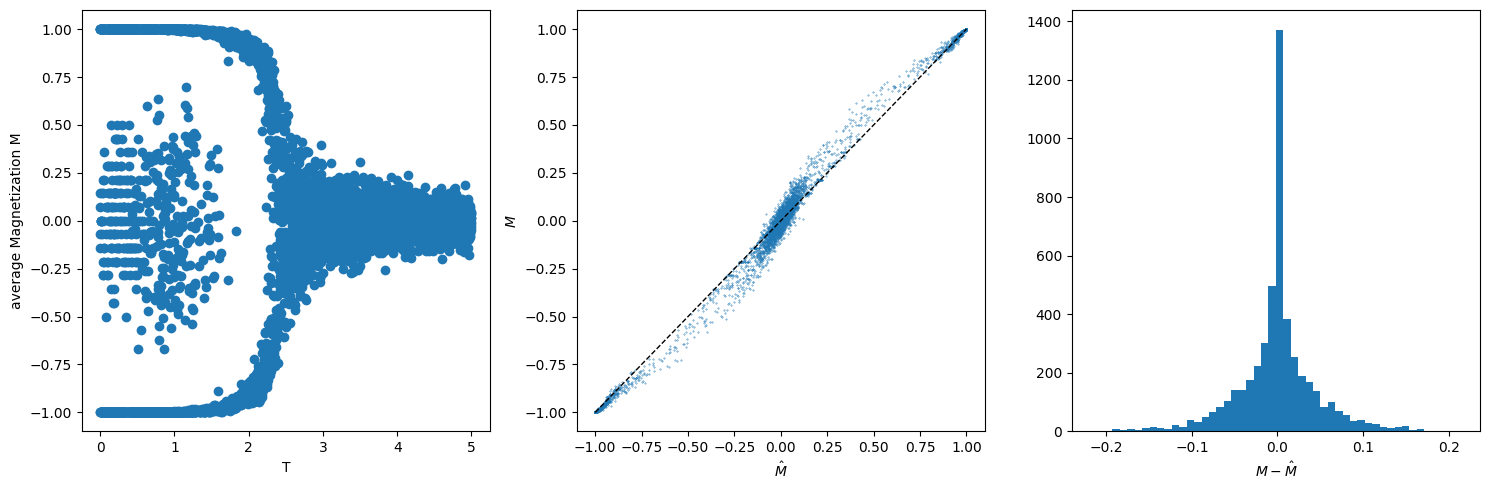

In [16]:
#@title Soluzione 3
# Scikit-learn Random Forest Regressor

from sklearn.model_selection import train_test_split
train_to_rest_ratio=0.6 # training sample 60%
vali_to_test_ratio=0.5  #  validation and test sets: 50%-50% of remianining 40%

# selezioniamo random data points dai campioni ordinati e disordinati per cerare training e test
X_train,X,Y_train,Y=train_test_split(data,temp,train_size=train_to_rest_ratio, shuffle=True, random_state=rnd_ini)
X_vali,X_test,Y_vali,Y_test=train_test_split(X,Y,train_size=vali_to_test_ratio, shuffle=True, random_state=rnd_ini)


#calcolo magenetizzazione media
M_train = np.sum(X_train, axis=1)/X_train.shape[1]
M_vali = np.sum(X_vali, axis=1)/X_train.shape[1]
M_test = np.sum(X_test, axis=1)/X_train.shape[1]

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import time
import warnings
#disabilitiamo messaggi di warning
warnings.filterwarnings("ignore")

myRF_reg = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=2, # minimum number of sample per leaf
    criterion='squared_error', #MSE loss (se si vuole usare la MAE: 'absolute_error')
    random_state=0
)

myRF_reg.fit(X_train, M_train)
score = myRF_reg.score(X_train, M_train)
val_score = myRF_reg.score(X_vali, M_vali)
test_score = myRF_reg.score(X_test, M_test)

print('coeff. of determination R^2 score (train/vali/test): ',score,val_score,test_score)

pred = myRF_reg.predict(X_test)
mae = mean_absolute_error(M_test, pred)
print('MAE test: ',mae)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(Y_test, M_test)
plt.xlabel('T')
plt.ylabel('average Magnetization M')

plt.subplot(1,3,2)
plt.scatter(pred, M_test, s=0.1)
plt.plot([-1,1],[-1,1], color='black', linewidth=1, linestyle='dashed')
plt.xlabel('$\hat{M}$')
plt.ylabel('$M$')

plt.subplot(1,3,3)
plt.hist(M_test-pred, bins=50)
plt.xlabel('$M-\hat{M}$')
plt.tight_layout()

**Per casa**

* provate a implementare una k-fold (con k=5) validation per l'ottimizzazione dei parametri della RandomForest e verificate se vi sono differenze rispetto all'uso del validation set o di OOB (OOB tende a dare delle stime molto pessimistiche).
    
NOTA: per imparare ad implementare una k-fold validation in scikit-learn guardate a questo [tutorial](https://scikit-learn.org/stable/modules/cross_validation.html)


* provare a implementare il punto 2 (classificatore) usando l'algoritmo di gradient boosting xGBoost

In [17]:
Y_train

array([0.771864, 4.54555 , 4.76471 , ..., 3.9743  , 0.407875, 0.993777])

In [18]:
#@title Esempio implementazione con xGBoost

import xgboost as xgb

X_train,X,Y_train,Y=train_test_split(data,labels,train_size=train_to_rest_ratio, shuffle=True, random_state=rnd_ini)
X_vali,X_test,Y_vali,Y_test=train_test_split(X,Y,train_size=vali_to_test_ratio, shuffle=True, random_state=rnd_ini)

# parametri del modello (vedere: https://xgboost.readthedocs.io/en/stable/python/python_api.html e
# https://xgboost.readthedocs.io/en/stable/parameter.html)
param_dist = {'objective':'multi:softmax', 'n_estimators':200}

# modello xGBoost classifier
xgb_model = xgb.XGBClassifier(**param_dist)

xgb_model.fit(X_train, Y_train,
              eval_set=[(X_train, Y_train), (X_test, Y_test)],
              eval_metric=['auc'], #area under the roc curve
              verbose=True)

test_pred = xgb_model.predict(X_test)
accuracy = xgb_model.score(X_test, Y_test)

print("Test Accuracy:")
print(accuracy)
print()

from sklearn.metrics import confusion_matrix
c_mat = confusion_matrix(Y_test, test_pred, normalize='true')
print("Confusion Matrix:")
print(c_mat)




[0]	validation_0-auc:0.94250	validation_1-auc:0.92714
[1]	validation_0-auc:0.96534	validation_1-auc:0.94933
[2]	validation_0-auc:0.97626	validation_1-auc:0.95967
[3]	validation_0-auc:0.98502	validation_1-auc:0.96852
[4]	validation_0-auc:0.98999	validation_1-auc:0.97419
[5]	validation_0-auc:0.99286	validation_1-auc:0.97795
[6]	validation_0-auc:0.99456	validation_1-auc:0.98018
[7]	validation_0-auc:0.99590	validation_1-auc:0.98216
[8]	validation_0-auc:0.99681	validation_1-auc:0.98455
[9]	validation_0-auc:0.99752	validation_1-auc:0.98620
[10]	validation_0-auc:0.99795	validation_1-auc:0.98728
[11]	validation_0-auc:0.99833	validation_1-auc:0.98833
[12]	validation_0-auc:0.99869	validation_1-auc:0.98892
[13]	validation_0-auc:0.99887	validation_1-auc:0.98974
[14]	validation_0-auc:0.99906	validation_1-auc:0.99044
[15]	validation_0-auc:0.99921	validation_1-auc:0.99111
[16]	validation_0-auc:0.99930	validation_1-auc:0.99146
[17]	validation_0-auc:0.99939	validation_1-auc:0.99137
[18]	validation_0-au